# ROB311 TP1
**Use KNN algorithm to detect breast cancer and haberman's survival result**

*Authors: Simon QUEYRUT, Zhi ZHOU*

---

## Breast cancer dataset

Imported libraries are meant to smooth process for generating test sets and trains sets or display good looking confusion matrices - the algorithm is still written from scratch.

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import operator
import sklearn
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Assign colum names to the dataset
colum_names = ['radius', 'texture', 'perimeter', 'area', 'smoothness',
         'compactness', 'concavity', 'concave points', 'symmetry', 'Class']

data_path = "./breast-cancer-wisconsin.data"

# Read dataset to pandas dataframe
dataset = pd.read_csv(data_path, names=colum_names)

# display example data
dataset.head()

,radius,texture,perimeter,area,smoothness,compactness,concavity,concave points,symmetry,Class
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2
1016277,6,8,8,1,3,4,3,7,1,2
1017023,4,1,1,3,2,1,3,1,1,2


In [39]:
# split features and labels apart
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# split up training data and test data, 80% of the data used for train and 20% used for test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.2)

print('training data size: ', X_train.shape)
X_train
print('test data size: ', X_test.shape)
X_test

training data size:  (559, 9)
test data size:  (140, 9)


array([[7, 8, 3, ..., 7, 8, 2],
       [1, 1, 1, ..., 1, 1, 1],
       [5, 4, 3, ..., 2, 3, 1],
       ...,
       [5, 1, 1, ..., 1, 1, 1],
       [5, 2, 2, ..., 1, 3, 1],
       [4, 1, 1, ..., 1, 1, 1]], dtype=object)

Then we plot the histograms of whether the cancer is benign or malignant respect to different features

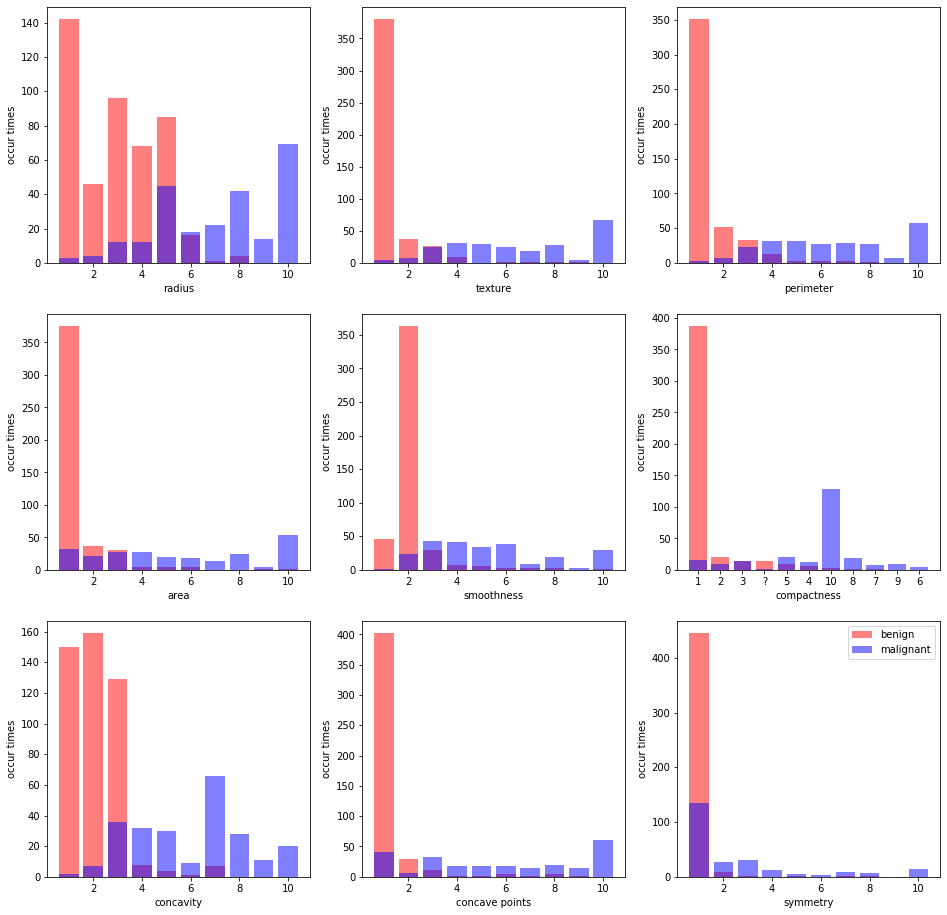

In [54]:
fig = plt.figure(figsize=(16, 16))
for i in range(9):
    plt.subplot(3, 3, i+1)  # set current subplot
    value_list_class2 = []  # list to store possible values of each features
    count_list_class2 = []  # list to store occurrence times of each features' value
    values_of_class2 = [item_x for item_x, item_y in zip(X[:, i].T, y) if int(item_y) == 2]
    # count the occurrence times of each features's value in a pd format
    value_count_pair = pd.value_counts(values_of_class2)  
    # separate the features' values and their occurrence times respectively
    for k in dict(value_count_pair):
        value_list_class2.append(k)
        count_list_class2.append(value_count_pair[k])
    plt.ylabel('occur times')
    plt.xlabel(colum_names[i])
    # plot histograms of benign cancer
    plt.bar(value_list_class2, count_list_class2, alpha=0.5, label='benign',fc = 'r')
    
    # repeat above step for malignant cancer
    value_list_class4 = []
    count_list_class4 = []
    values_of_class4 = [item_x for item_x, item_y in zip(X[:, i].T, y) if int(item_y) == 4]
    value_count_pair = pd.value_counts(values_of_class4)
    for i in dict(value_count_pair):
        value_list_class4.append(i)
        count_list_class4.append(value_count_pair[i])
    plt.bar(value_list_class4, count_list_class4, alpha=0.5, label='malignant',fc = 'b')    

plt.legend()

From above images, we could see that most benign cancers tend to have small value of each feature, whereas malignant cancers' are various and tend to have larger values.

We choose euclidean distance to measure the difference between test data and training data:
<p style="text-align: center;">
$\sqrt{\sum_{i=1}^{n}{(X_i - \overline{X_i})^2}}$
</p>

In [37]:
# function used for calculating euclidean distance
def euclidian_distance(X_test, X_train, length):  
    """
    Args:
        X_test:
        X_train:
        length:

    Returns:
        euclidean distance 
    """
    distance = 0
    for x in range(length):
        x_test_x = X_test[x]
        x_train_x = X_train[x]
            
        # missing value represented by question mark are replaced by 0:
        if x_train_x == '?':
            x_train_x = 0
        if x_test_x == '?':
            x_test_x = 0
        distance += np.square(int(x_test_x) - int(x_train_x))
    return np.sqrt(distance)


The `winner_from_dict` function returns the class with most occurrences among shortest distances:

In [38]:
def winner_from_dict(pseudo_dict, k):
    """returns winner from sorted pseudo-dict, for example:

    winner_from_dict(
    [(4.898979485566356, 1), (5.916079783099616, 1), (6.708203932499369, 1),
    (6.782329983125268, 1), (7.280109889280518, 1), (8.12403840463596, 1),
    (8.12403840463596, 1), (8.602325267042627, 2), (8.94427190999916, 2),
    (9.0, 2), (9.055385138137417, 1), ...] , 8)

    would return 1.

    Args:
        pseudo_dict (list):
        k (int):
    Returns:
        winner_class (int): class with most occurrence in sorted distance 
        pseudo-dict
    """
    sorted_tuple_list = Sort(pseudo_dict)  # min to max euclidean distance
    pool = []                              # to store the k-nearest classes
    for i in range(k):
        current_couple = sorted_tuple_list[k]
        candidate = current_couple[1]
        pool.append(candidate)
    # count and return the most frequent class
    winner_class = max(set(pool), key=pool.count)
    return winner_class

def Sort(tup):
    """
    sorts a list of tuple from min to max with respect to first argument
    """
    return(sorted(tup, key = lambda x: float(x[0])))

We may now run the algorithm:

In [39]:
distance_list = []     # a list used to store all the distances calculated
class_list = []        # a list used to store all predicted classification result
K = 3                  # define K parameter
test_sample_index = 0  # index of current test sample

for test_sample in X_test:
    distance_list.append([])
    for train_data in X_train:
        distance_list[test_sample_index].append(euclidian_distance(test_sample, 
                                                                   train_data, 9))
    # pseudo_dict is basically a dict with one-key-several-values ability, since 
    # two training data of different class can be at the same distance of the
    # test sample...
    pseudo_dict = [(distance_list[test_sample_index][i], y_train[i]) for i
                   in range(len(y_train))]

    res = winner_from_dict(pseudo_dict, K)
    class_list.append(res)
    test_sample_index += 1  # we move on to the next test sample

Normalized confusion matrix
[[0.9673913  0.0326087 ]
 [0.08333333 0.91666667]]


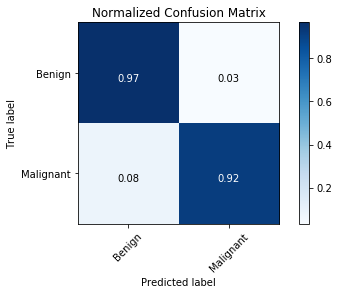

In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 verticalalignment='top',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()  
    
cm = confusion_matrix(y_test, class_list)
class_names = ['Benign', 'Malignant']
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Normalized Confusion Matrix')

We then compute the accuracy defined by 

$$\frac{TP + TN}{P+N}$$

with the following snippet:


In [41]:
sum(1 for x,y in zip(y_test,class_list) if x == y) / len(y_test)

0.95

The algorithm shows good performance on this dataset since we have <5% confusion probability for the first class and slightly worse for the second one. Still acceptable considering the dataset is very small.

---

## Haberman dataset

In [55]:
url = "./haberman.data"

# Assign colum names to the dataset
names = ['patient_age', 'operation_year', 'nb_positive_node', 'Class']

# Read dataset to pandas dataframe
dataset = pd.read_csv(url, names=names)

# display example data
dataset.head()

,patient_age,operation_year,nb_positive_node,Class
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


In [56]:
# split features and labels
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,
stratify=y, test_size=0.2)

# print training data and test data sizes
print('training data size: ', X_train.shape)
print('test data size: ', X_test.shape)

training data size:  (244, 3)
test data size:  (62, 3)


Then we plot the histograms of whether patient survived 5+ years or not respect to different features

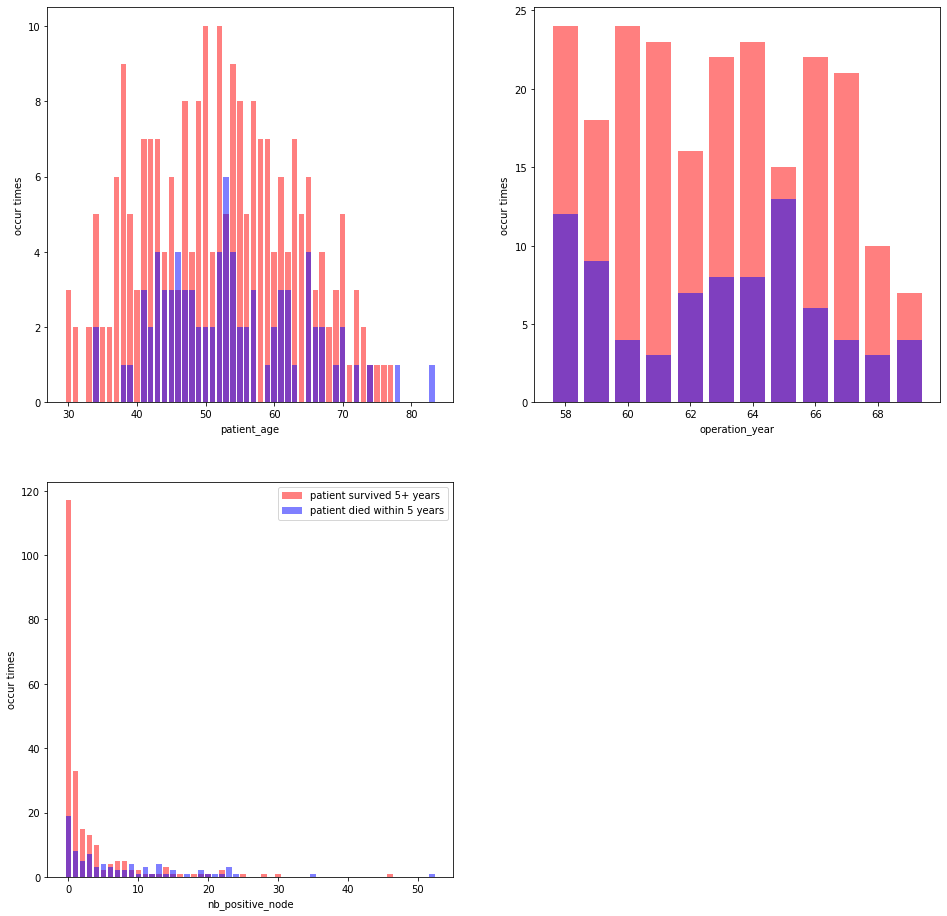

In [58]:
fig = plt.figure(figsize=(16, 16))
for i in range(3):
    plt.subplot(2, 2, i+1)  # set current subplot
    value_list_class2 = []  # list to store possible values of each features
    count_list_class2 = []  # list to store occurrence times of each features' value
    values_of_class2 = [item_x for item_x, item_y in zip(X[:, i].T, y) if int(item_y) == 1]
    # count the occurrence times of each features's value in a pd format
    value_count_pair = pd.value_counts(values_of_class2)  
    # separate the features' values and their occurrence times respectively
    for k in dict(value_count_pair):
        value_list_class2.append(k)
        count_list_class2.append(value_count_pair[k])
    plt.ylabel('occur times')
    plt.xlabel(names[i])
    # plot histograms of benign cancer
    plt.bar(value_list_class2, count_list_class2, alpha=0.5, label='patient survived 5+ years',fc = 'r')
    
    # repeat above step for malignant cancer
    value_list_class4 = []
    count_list_class4 = []
    values_of_class4 = [item_x for item_x, item_y in zip(X[:, i].T, y) if int(item_y) == 2]
    value_count_pair = pd.value_counts(values_of_class4)
    for i in dict(value_count_pair):
        value_list_class4.append(i)
        count_list_class4.append(value_count_pair[i])
    plt.bar(value_list_class4, count_list_class4, alpha=0.5, label='patient died within 5 years',fc = 'b')    

plt.legend()

From above images we could see that most patients' year are between 40 and 70, the operation year is quite various

let us run the algorithm and compute the confusion matrix:

Normalized confusion matrix
[[0.84782609 0.15217391]
 [0.6875     0.3125    ]]


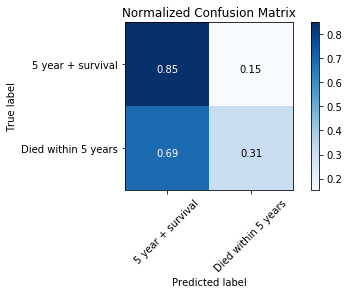

In [44]:
distance_list = []     # a list used to store all the distances calculated
class_list = []        # a list used to store all predicted classification result
K = 4                  # define K parameter
test_sample_index = 0  # index of current test sample

for test_sample in X_test:
    distance_list.append([])
    for train_data in X_train:
        distance_list[test_sample_index].append(euclidian_distance(test_sample,
                                                                   train_data, 3))
    # pseudo_dict is basically a dict with one-key-several-values ability, since 
    # two training data of different class can be at the same distance of the
    # test sample...
    pseudo_dict = [(distance_list[test_sample_index][i], y_train[i]) for i
                   in range(len(y_train))]

    res = winner_from_dict(pseudo_dict, K)
    class_list.append(res)
    test_sample_index += 1

C = confusion_matrix(y_test, class_list)
class_names = ['5 year + survival', 'Died within 5 years']
plot_confusion_matrix(C, classes=class_names, normalize=True,
                      title='Normalized Confusion Matrix')


and then the accuracy:

In [45]:
sum(1 for x,y in zip(y_test,class_list) if x == y) / len(y_test)

0.7096774193548387

The algorithm shows bad performance with Haberman dataset since there is more than 0.5 probability to mislabel a sample that corresponds to the *Died within 5 years* feature.
It may be due to the fact that:
 - the dataset is small;
 - there are too few features;
 - some features may be less significant for the training (e.g. maybe the year of operation is not that important considering improvements on surgical techniques take several decades to display significant evolutions)
 
The first dataset had twice as many data and had many more carefully selected physical features, thus the algorithm had better performance.

However, it does deliver correct output for the *5 years + survival* feature with <16% error probability, still acceptable for small dataset.

## Conclusion
We used our from-scratch implementation of k-NN algorithm on two datasets.

- For the first dataset (breast cancer), the algorithm outputs good results (95% accuracy, <3% error probability for the first class and <10% for the second one). 
- For the second dataset (Haberman survival), the algorithm behaves correctly for the first feature but badly for the second one (*Died within 5 years*) with an overall accuracy of 71%.
- Each time we chose the value for k that gave the best results, namely 3 and 4.